# <center>Metody Numeryczne</center>

# Laboratorium 9: Interpolacja


**Wykonał:** \<imię i nazwisko\>

<br>

### **Metoda zaliczenia:**

Podczas zajęć należy wykonać poniższe polecenia oraz udzielić odpowiedzi na pytania zamieszczone w treści zadań. 

Wszystkie funkcje wymagane w ramach ćwiczenia należy zaimplementować w pliku `main.py`. Poprawność ich działania należy zweryfikować za pomocą testów jednostkowych dostępnych w pliku `test_main.py`.

### **Cel zajęć:**

Celem laboratorium jest praktyczne zapoznanie z zagadnieniem interpolacji wielomianowej, ze szczególnym uwzględnieniem jej wariantów numerycznie stabilnych. W ramach zajęć przeanalizowane zostanie działanie interpolacji barycentrycznej opartej na węzłach Czebyszewa.


### **Uwagi wstępne:**
- Funkcje wymagające implementacji (lub zaimplementowane na poprzednich laboratoriach) oznaczone są pochyłą czcionką maszynową (np. *`my_func()`*).

- W skrypcie stosuje się następujące skróty:

    - `np` - `numpy`,
    - `sp` - `scipy`.

---

In [21]:
# !python -m pip install numpy scipy matplotlib

import main

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

---

### **Zadanie 1.**

W celu wykonywania interpolacji należy przygotować funkcję wyliczającą wektor [węzłów Czebyszewa](https://en.wikipedia.org/wiki/Chebyshev_nodes) drugiego rodzaju (funkcja *`chebyshev_nodes()`*) dany wzorem:
  
$$
x_k = \cos\left(\cfrac{k\pi}{n}\right),\ \ \ k = 0,1,2,...,n
$$

oraz wagi barycentryczne dla tego typu wezłów (funkcja *`bar_cheb_weights()`*):

$$
\begin{align*}
    w_j={}&(-1)^j\delta_j\\
    \delta_j={}&
    \begin{cases}
        \frac{1}{2}, \quad j=\{0, n\}\\
        1, \quad j\in(0,n)
    \end{cases}
\end{align*}
$$


In [22]:
def chebyshev_nodes(n: int = 10) -> np.ndarray | None:
    """Funkcja generująca wektor węzłów Czebyszewa drugiego rodzaju (n,) 
    i sortująca wynik od najmniejszego do największego węzła.

    Args:
        n (int): Liczba węzłów Czebyszewa.
    
    Returns:
        (np.ndarray): Wektor węzłów Czebyszewa (n,).
        Jeżeli dane wejściowe są niepoprawne funkcja zwraca `None`.
    """
    if n <= 0 or not isinstance(n, int):
        return None
    cz = np.array([np.cos(k * np.pi / (n-1)) for k in range(n)])
    return cz

def bar_cheb_weights(n: int = 10) -> np.ndarray | None:
    """Funkcja tworząca wektor wag dla węzłów Czebyszewa wymiaru (n,).

    Args:
        n (int): Liczba wag węzłów Czebyszewa.
    
    Returns:
        (np.ndarray): Wektor wag dla węzłów Czebyszewa (n,).
        Jeżeli dane wejściowe są niepoprawne funkcja zwraca `None`.
    """
    if n <= 0 or not isinstance(n, int):
        return None
    w = np.ones(n)
    w[0] = 0.5
    w[-1] = 0.5 * (-1) ** (n - 1)
    for j in range(1, n - 1):
        w[j] = (-1) ** j
    return w 

---

### **Zadanie 2.**

Zaimplementuj podane funkcje, które będą używane w dalszej części laboratorium:

1. Ciągłą nieróżniczkowalną: $f_1(x) = \mathrm{sgn}(x)x+x^2$.

2. Różniczkowalną jednokrotnie: $f_2(x) = \mathrm{sgn}(x)x^{2}$.

3. Różniczkowalną trzykrotnie: $f_3(x)=|\sin(5 x)|^3$.

4. Trzy analityczne postaci: $f_{4a}(x) = \cfrac{1}{1+ax^2} \ $ dla $a \in \{1,25,100\}$. 

5. Nieciągłą: $f_5(x) = \mathrm{sgn}(x)$.

Funkcje można zaimplementować w notebooku lub w pliku `main.py`. 

>**Wskazówka:** Do definicji funkcji w notatniku można użyć [wyrażenia lambda](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions).
>
>$\mathrm{sgn}(x)$ to funkcja [signum](https://en.wikipedia.org/wiki/Sign_function).

In [23]:
# ===== Twoja implementacja tutaj =====
def f1(x: float) -> float:
    return np.sign(x)*x + x**2
def f2(x: float) -> float:
    return np.sign(x)*x**2
def f3(x: float) -> float:
    return abs(np.sin(5*x))**3
def f4_1(x: float) -> float:
    return 1 / (1 + x**2)
def f4_25(x: float) -> float:
    return 1 / (1 + 25 * x**2)
def f4_100(x: float) -> float:
    return 1 / (1 + 100 * x**2)
def f5(x: float) -> float:
    return np.sign(x)
# ======================================

---

### **Zadanie 3.**

Do oceny jakości interpolacji stosuje się normę wektorową $\ell_{\infty}$. Dla różnicy wektorów definiujemy ją jako:  
  
$$
\ell_{\infty} = ||\mathbf{x_1}-\mathbf{x_2}||_\infty = \sup\{|\mathbf{x_1}-\mathbf{x_2}|\}
$$  
  
Zaimplementuj funkcję *`L_inf()`* wyznaczającą normę $\ell_{\infty}$. 


In [24]:
def L_inf(
    xr: int | float | list | np.ndarray, x: int | float | list | np.ndarray
) -> float | None:
    """Funkcja obliczająca normę L-nieskończoność. Powinna działać zarówno na 
    wartościach skalarnych, listach, jak i wektorach biblioteki numpy.

    Args:
        xr (int | float | list | np.ndarray): Wartość dokładna w postaci 
            skalara, listy lub wektora (n,).
        x (int | float | list | np.ndarray): Wartość przybliżona w postaci 
            skalara, listy lub wektora (n,).

    Returns:
        (float): Wartość normy L-nieskończoność.
        Jeżeli dane wejściowe są niepoprawne funkcja zwraca `None`.
    """
    if isinstance(xr, (int, float)) and isinstance(x, (int, float)):
        xr = np.array([xr])
        x = np.array([x])
        return np.linalg.norm(xr - x, np.inf)
    elif isinstance(xr, list) and isinstance(x, list) and len(xr) == len(x):
        xr = np.array(xr)
        x = np.array(x)
        return np.linalg.norm(xr - x, np.inf)
    elif isinstance(xr, np.ndarray) and isinstance(x, np.ndarray) and xr.shape == x.shape:
        return np.linalg.norm(xr - x, np.inf)
    else:
        return None

---

### **Zadanie 4.**

**Punkt 1.**

Zaimlementuj wzór barycentryczny podany na wykładzie jako funkcję *`barycentric_inte()`*.

<br>

**Punkt 2.**

Dla funkcji ciągłej nieróżniczkowalnej z **Zadania 2.** ($f_1(x)$) przeprowadź interpolację metodą [barycentryczną](https://people.maths.ox.ac.uk/trefethen/barycentric.pdf) zarówno przy użyciu funkcji [`sp.interpolate.barycentric_interpolate()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.barycentric_interpolate.html) jak i korzystając z zaimplementowanego wzoru barycentrycznego. 

W tym celu dla $n \in \{1, 2, 3, 4, 5\}$:

1. W węzłach Czebyszewa wykonaj interpolację rzędu $10^n$.

2. Wykreśl wykresy obrazujące wyniki interpolacji (wykres oryginalnej funkcji i funkcji interpolującej w $1000$ punktach).

3. Zbadaj jakość interpolacji za pomocą normy $\ell_{\infty}$.

Opisz jak zmieniały się wartość normy $\ell_{\infty}$ oraz czas obliczeń w zależności od rzędu interpolacji.


In [25]:
def barycentric_inte(
    xi: np.ndarray, yi: np.ndarray, wi: np.ndarray, x: np.ndarray
) -> np.ndarray | None:
    """Funkcja przeprowadza interpolację metodą barycentryczną dla zadanych 
    węzłów xi i wartości funkcji interpolowanej yi używając wag wi. Zwraca 
    wyliczone wartości funkcji interpolującej dla argumentów x w postaci 
    wektora (n,).

    Args:
        xi (np.ndarray): Wektor węzłów interpolacji (m,).
        yi (np.ndarray): Wektor wartości funkcji interpolowanej w węzłach (m,).
        wi (np.ndarray): Wektor wag interpolacji (m,).
        x (np.ndarray): Wektor argumentów dla funkcji interpolującej (n,).
    
    Returns:
        (np.ndarray): Wektor wartości funkcji interpolującej (n,).
        Jeżeli dane wejściowe są niepoprawne funkcja zwraca `None`.
    """
    if isinstance(xi, np.ndarray) and isinstance(yi, np.ndarray) and isinstance(wi, np.ndarray) and isinstance(x, np.ndarray):
        if xi.shape != yi.shape or xi.shape != wi.shape:
            return None
        n = xi.shape[0]
        m = x.shape[0]
        p = np.zeros(m)
        for j in range(m):
            numerator = 0.0
            denominator = 0.0
            for i in range(n):
                if x[j] == xi[i]:
                    numerator = yi[i]
                    denominator = 1.0
                    break
                temp = wi[i] / (x[j] - xi[i])
                numerator += temp * yi[i]
                denominator += temp
            p[j] = numerator / denominator
        return p
    return None

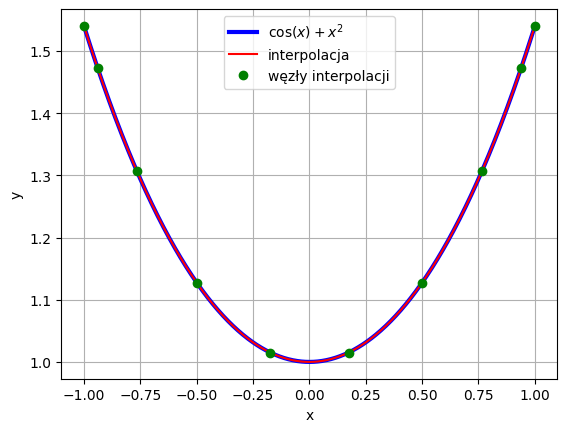

In [26]:
# Przykład użycia interpolacji barycentrycznej z wykorzystaniem węzłów Czebyszewa

# Funkcja do interpolacji
def f(x):
    return np.cos(x) + x**2

# Wektor współrzędnych, dla których chcemy wyliczyć wartości wielomianu interpolacyjnego
x = np.linspace(-1, 1, 1000)

# Węzły Czebyszewa
n = int(1e1)  # Liczba węzłów
xch = chebyshev_nodes(n)

# Interpoalcja
yimp = sp.interpolate.barycentric_interpolate(xch, f(xch), x)

plt.plot(x, f(x), 'b', linewidth=3, label=r'$\cos(x)+x^2$')
plt.plot(x, yimp, 'r', label='interpolacja')
plt.plot(xch, f(xch), 'go', label='węzły interpolacji')
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc=0)
plt.grid()
plt.show()

357 μs ± 31 μs per loop (mean ± std. dev. of 3 runs, 1,000 loops each)
8.07 ms ± 111 μs per loop (mean ± std. dev. of 3 runs, 100 loops each)


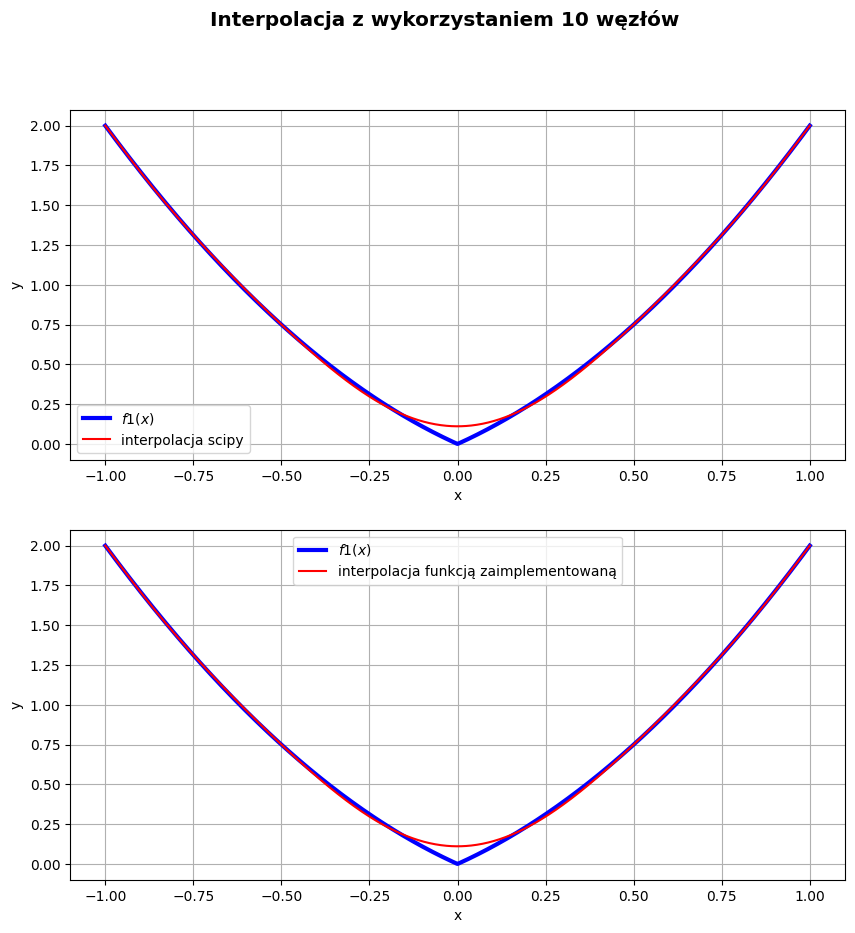

2.06 ms ± 51.9 μs per loop (mean ± std. dev. of 3 runs, 100 loops each)
86.5 ms ± 7.01 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


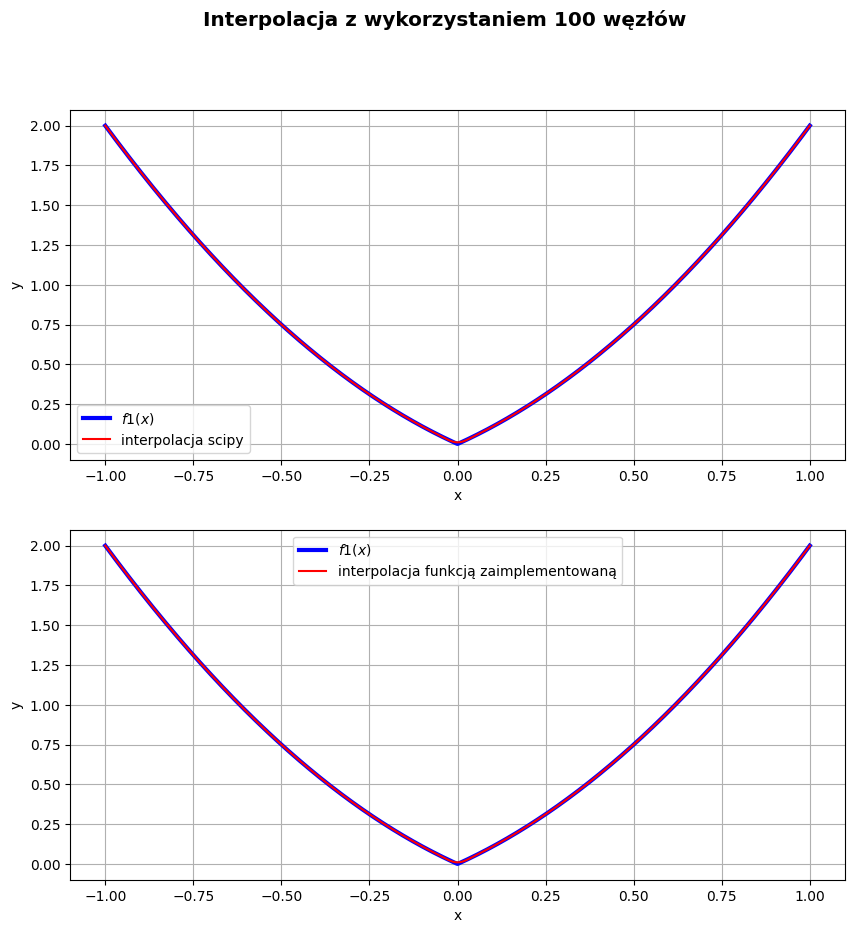

33.8 ms ± 3.11 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
903 ms ± 69.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


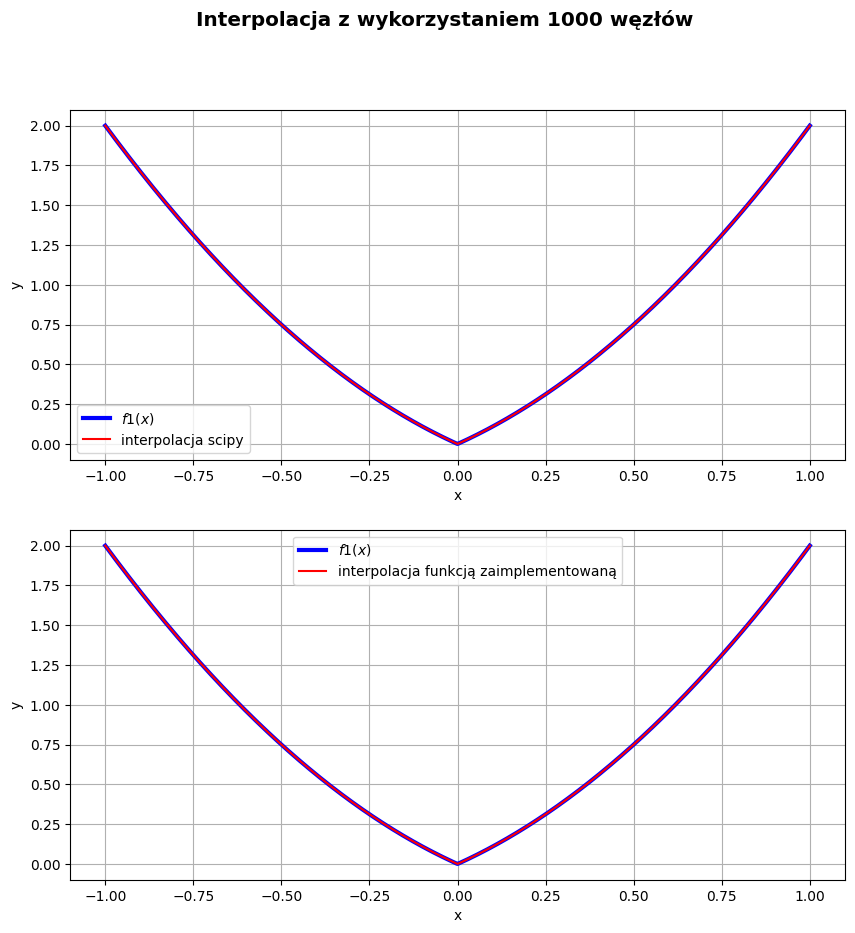

534 ms ± 34.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
8.94 s ± 750 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


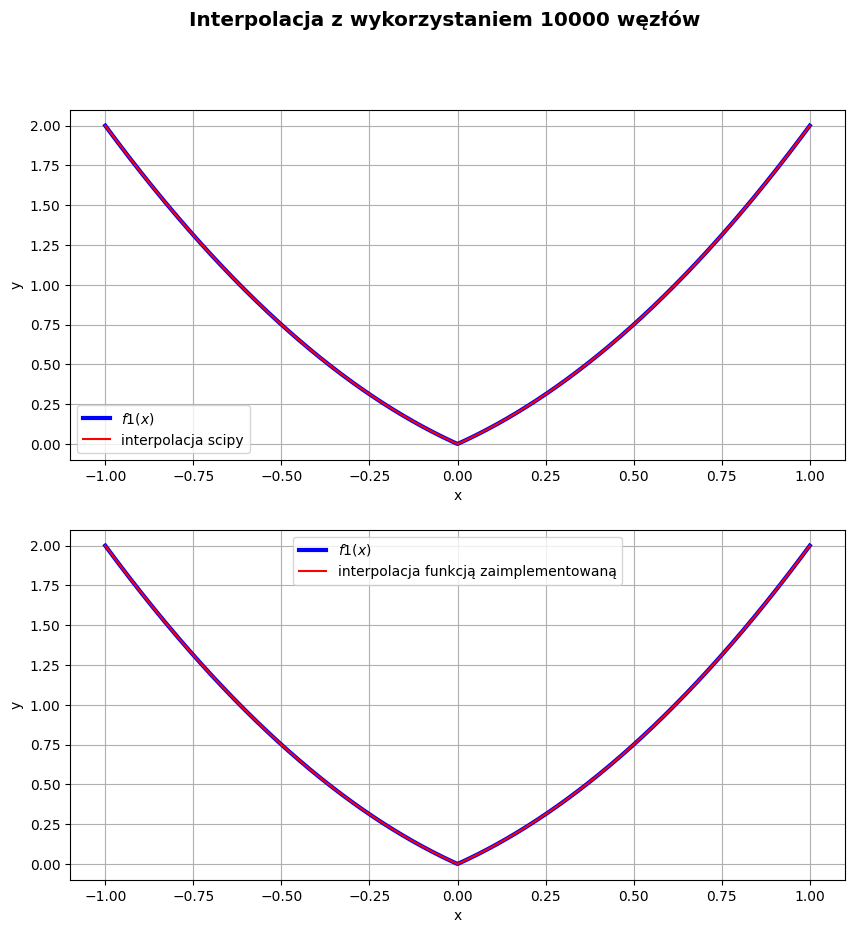

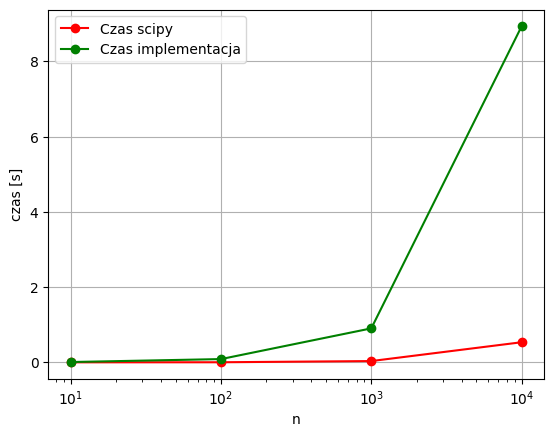

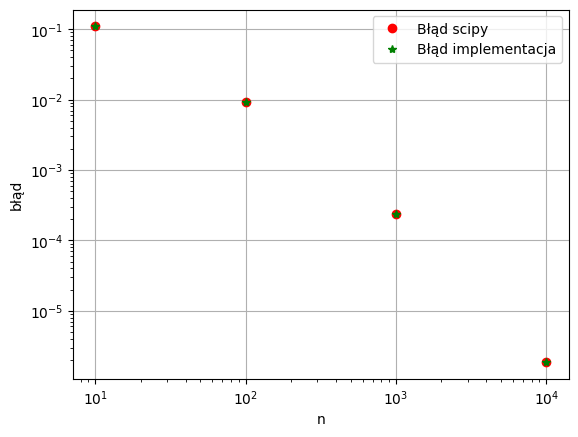

In [ ]:
# ===== Twoja implementacja tutaj =====
# Wektor współrzędnych, dla których chcemy wyliczyć wartości wielomianu interpolacyjnego
x = np.linspace(-1, 1, 1000)
n_values = [1e1, 1e2, 1e3, 1e4] #pominięto 1e5 ze względu na czas wykonania i błędy z tym związane
time_sp = []
l_norm_sp = []
time_imp = []
l_norm_imp = []
for n in n_values:
    xch = chebyshev_nodes(int(n))

    y_sp = sp.interpolate.barycentric_interpolate(xch, f1(xch), x)
    t = %timeit -r 3 -o sp.interpolate.barycentric_interpolate(xch, f1(xch), x)
    time_sp.append(t.average)
    l_norm_sp.append(L_inf(f1(x), y_sp))

    x_w = bar_cheb_weights(int(n))
    y_imp = barycentric_inte(xch, f1(xch), x_w, x)
    t = %timeit -r 3 -o barycentric_inte(xch, f1(xch), x_w, x)
    time_imp.append(t.average)
    l_norm_imp.append(L_inf(f1(x), y_imp))

    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    ax[0].plot(x, f1(x), 'b', linewidth=3, label=r'$f1(x)$')
    ax[0].plot(x, y_sp, 'r', label='interpolacja scipy')
    ax[1].plot(x, f1(x), 'b', linewidth=3, label=r'$f1(x)$')
    ax[1].plot(x, y_imp, 'r', label='interpolacja funkcją zaimplementowaną')
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")
    ax[0].legend(loc=0)
    ax[0].grid()
    ax[1].set_xlabel("x")
    ax[1].set_ylabel("y")
    ax[1].legend(loc=0)
    ax[1].grid()
    fig.suptitle('Interpolacja z wykorzystaniem {0} węzłów'.format(int(n)), fontweight ="bold", fontsize='x-large')
    plt.show()    
plt.plot(n_values, time_sp, 'r-o', label='Czas scipy')    
plt.plot(n_values, time_imp, 'g-o', label='Czas implementacja')
plt.xlabel("n")
plt.ylabel("czas [s]")
plt.xscale('log')
plt.legend(loc=0)
plt.grid()
plt.show()

plt.plot(n_values, l_norm_sp, 'ro', label='Błąd scipy')    
plt.plot(n_values, l_norm_imp, 'g*', label='Błąd implementacja')
plt.xlabel("n")
plt.ylabel("błąd")
plt.legend(loc=0)
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.show()

---

### **Zadanie 5.**

Dla funkcji jednokrotnie ($f_2(x)$) i trzykrotnie ($f_3(x)$) różniczkowalnych z **Zadania 2.** należy przeanalizować w pętli jakość interpolacji dla interpolacji rzędu $10^n$, gdzie $n \in \{1, 2, 3, 4, 5\}$. 

W tym celu:

1. Wylicz wartość funkcji i wielomianu interpolacyjnego w $1000$ punktów (nie będącymi węzłami interpolacji np. punkty równoodległe).

2. Wylicz normę różnicy tych wektorów (normę błędu) dla każdego badanego rzędu. Maksymalny rząd należy przyjąć gdy błąd będzie na poziomie zera maszynowego.

3. Dla każdej z funkcji sporządź wykres w skali podwójnie logarytmicznej (obie osie), w którym oś argumentów to rząd interpolacji a oś wartości to odpowiadająca mu norma błędu.

4. Dla porównania umieść na wykresie dodatkowo wykres $n^{-v}$, gdzie $v$ to rząd najwyższej pochodnej funkcji (zobacz wykład).

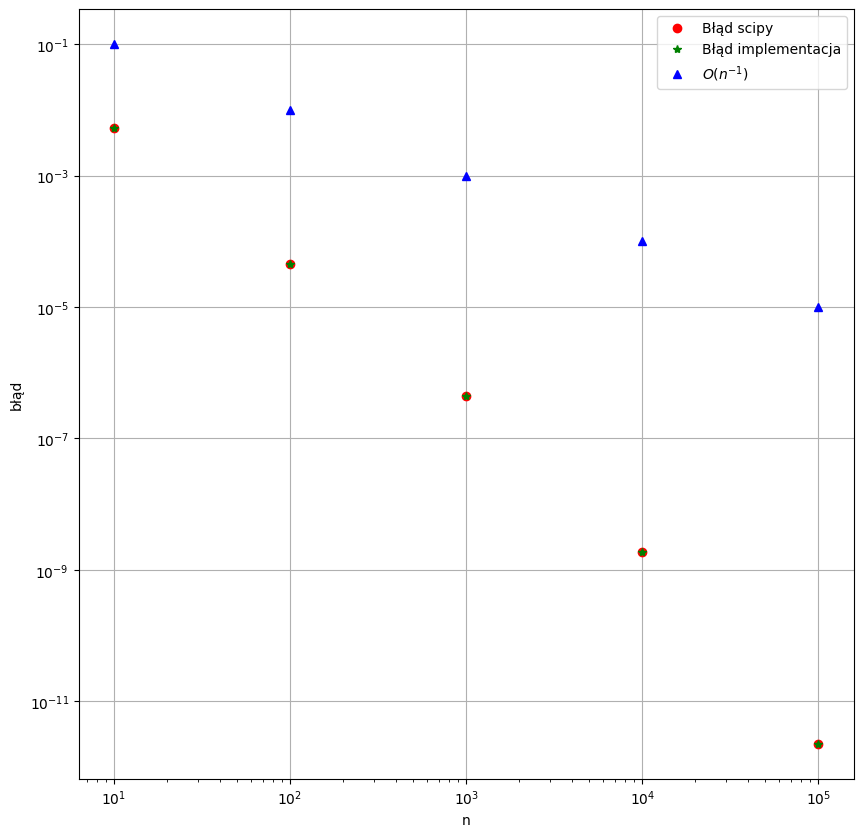

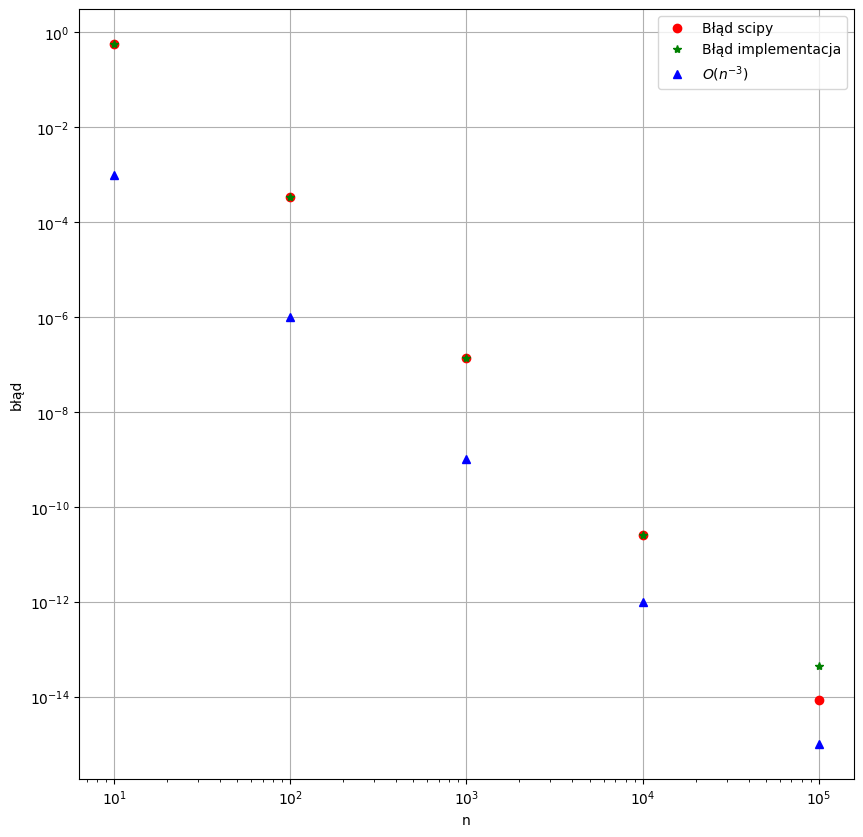

In [31]:
# ===== Twoja implementacja tutaj =====
n_values = [10, 100, 1000, 10000, 100000]
eps = 1e-16
#f2 1-krotnie różniczkowalna
x = np.linspace(-1, 1, 1000)
sp_norms = []
imp_norms = []
for n in n_values:
    try:
        xch = chebyshev_nodes(int(n))
        
        y_sp = sp.interpolate.barycentric_interpolate(xch, f2(xch), x)
        norm_sp = L_inf(f2(x), y_sp)
        if norm_sp >= eps:
            sp_norms.append(norm_sp)
            
        x_w = bar_cheb_weights(int(n))
        y_imp = barycentric_inte(xch, f2(xch), x_w, x)
        norm_imp = L_inf(f2(x), y_imp)
        if norm_imp >= eps:
            imp_norms.append(norm_imp)
            
    except ValueError as e:
        print(f"SciPy poległo dla n={n}: {e}")
    except Exception as e:
        print(f"Inny błąd dla n={n}: {e}")

plt.figure(figsize=(10, 10))
plt.plot(n_values[:len(sp_norms)], sp_norms, 'ro', label='Błąd scipy')    
plt.plot(n_values[:len(imp_norms)], imp_norms, 'g*', label='Błąd implementacja')
plt.plot(n_values[:len(imp_norms)], [n**(-1) for n in n_values[:len(imp_norms)]], 'b^', label=r'$O(n^{-1})$')
plt.xlabel("n")
plt.ylabel("błąd")
plt.legend(loc=0)
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.show()
#f3 3-krotnie różniczkowalna
x = np.linspace(-1, 1, 1000)
sp_norms = []
imp_norms = []
for n in n_values:
    try:
        xch = chebyshev_nodes(int(n))
        
        y_sp = sp.interpolate.barycentric_interpolate(xch, f3(xch), x)
        norm_sp = L_inf(f3(x), y_sp)
        if norm_sp >= eps:
            sp_norms.append(norm_sp)
            
        x_w = bar_cheb_weights(int(n))
        y_imp = barycentric_inte(xch, f3(xch), x_w, x)
        norm_imp = L_inf(f3(x), y_imp)
        if norm_imp >= eps:
            imp_norms.append(norm_imp)
            
    except ValueError as e:
        print(f"SciPy poległo dla n={n}: {e}")
    except Exception as e:
        print(f"Inny błąd dla n={n}: {e}")

plt.figure(figsize=(10, 10))
plt.plot(n_values[:len(sp_norms)], sp_norms, 'ro', label='Błąd scipy')    
plt.plot(n_values[:len(imp_norms)], imp_norms, 'g*', label='Błąd implementacja')
plt.plot(n_values[:len(imp_norms)], [n**(-3) for n in n_values[:len(imp_norms)]], 'b^', label=r'$O(n^{-3})$')
plt.xlabel("n")
plt.ylabel("błąd")
plt.legend(loc=0)
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.show()

---

### **Zadanie 6.**

Dla funkcji nieciągłej z **Zadania 2.** ($f_5(x)$) przeanalizować należy [efekt Gibbsa](https://en.wikipedia.org/wiki/Gibbs_phenomenon).

1. Oddzielnie dla parzystych i nieparzystych $n$ wylicz jaki jest minimalny błąd niezależny od rzędu. 

2. Odpowiedz dlaczego wartości dla parzystych i nieparzystych $n$ się różnią.

> **Wskazówka:** Wykonaj wykres funkcji i jej funkcji interpolującej.

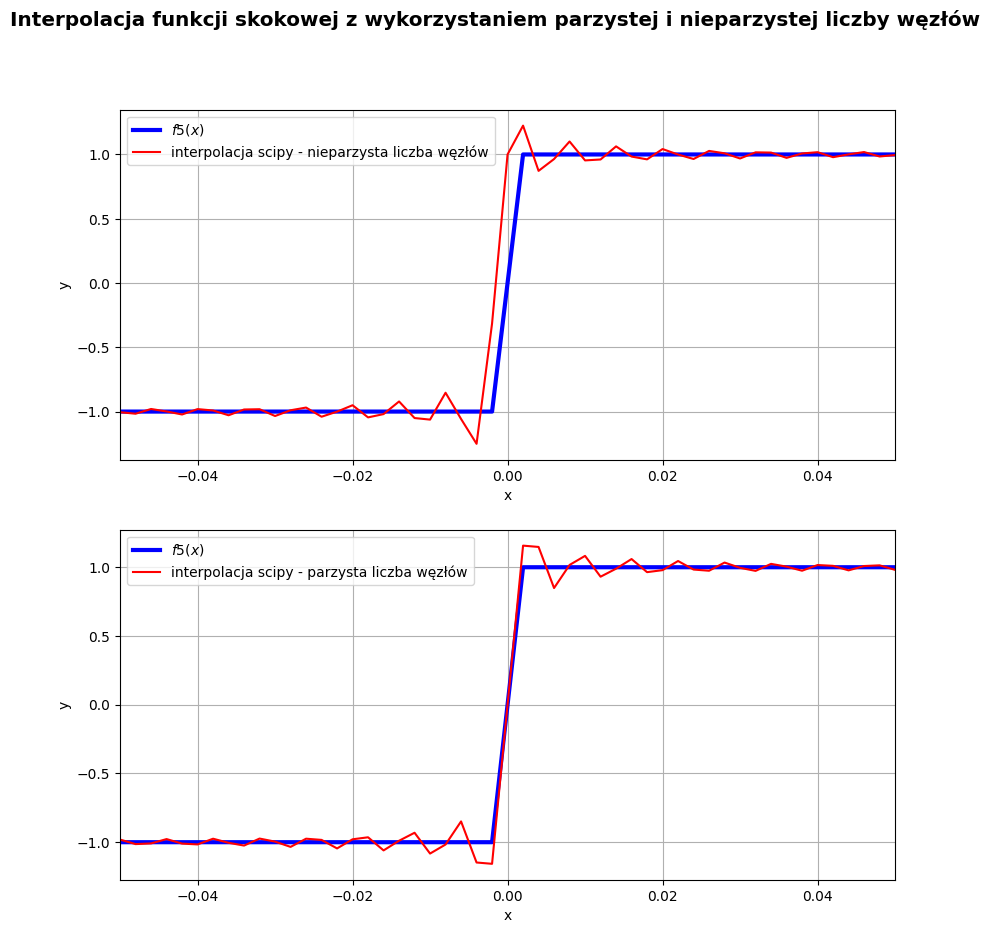

Błąd dla nieparzystej liczby węzłów: 0.9999999999999762
Błąd dla parzystej liczby węzłów: 0.15717666737453473


In [29]:
# ===== Twoja implementacja tutaj =====
x = np.linspace(-1, 1, 1001)
n = 1000
xch_odd = chebyshev_nodes(n + 1)  # n jest parzyste, więc n+1 jest nieparzyste
xch_even = chebyshev_nodes(n)    # n jest parzyste
y_sp_odd = sp.interpolate.barycentric_interpolate(xch_odd, f5(xch_odd), x)
y_sp_even = sp.interpolate.barycentric_interpolate(xch_even, f5(xch_even), x)
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(x, f5(x), 'b', linewidth=3, label=r'$f5(x)$')
ax[0].plot(x, y_sp_odd, 'r', label='interpolacja scipy - nieparzysta liczba węzłów')
ax[1].plot(x, f5(x), 'b', linewidth=3, label=r'$f5(x)$')
ax[1].plot(x, y_sp_even, 'r', label='interpolacja scipy - parzysta liczba węzłów')
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_xlim([-0.05, 0.05])
ax[0].legend(loc=0)
ax[0].grid()
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_xlim([-0.05, 0.05])
ax[1].legend(loc=0)
ax[1].grid()
fig.suptitle('Interpolacja funkcji skokowej z wykorzystaniem parzystej i nieparzystej liczby węzłów', fontweight ="bold", fontsize='x-large')
plt.show()

error_odd = L_inf(f5(x), y_sp_odd)
error_even = L_inf(f5(x), y_sp_even)
print(f"Błąd dla nieparzystej liczby węzłów: {error_odd}")
print(f"Błąd dla parzystej liczby węzłów: {error_even}")

---

Różnica wynika z tego, że dla n nieparzystych jeden z węzłów wypada w punkcie nieciągłości (0), co wpływa na gorszą jakość interpolacji w okolicy zera w porównaniu do n parzystego.

**Materiały uzupełniające:**
- [Scipy Lecture Notes](http://www.scipy-lectures.org/index.html)
- [NumPy for Matlab users](https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html#numpy-for-matlab-users)
- [Python Tutorial - W3Schools](https://www.w3schools.com/python/default.asp)
- [NumPy](https://www.numpy.org)
- [Matplotlib](https://matplotlib.org/)
- [Anaconda](https://www.anaconda.com/)
- [Learn Python for Data Science](https://www.datacamp.com/learn-python-with-anaconda?utm_source=Anaconda_download&utm_campaign=datacamp_training&utm_medium=banner)
- [Learn Python](https://www.learnpython.org/)
- [Wujek Google](https://google.pl) i [Ciocia Wikipedia](https://pl.wikipedia.org/wiki/Wikipedia:Strona_g%C5%82%C3%B3wna)